# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import es_core_news_sm

from collections import Counter
import itertools
from wordcloud import WordCloud

In [2]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

# A - Exploración de datos y Procesamiento del Lenguaje Natural

Tanto el dataset de formación como el de prueba cuentan con <code>5000 reviews</code>, mientras que el de entrenamiento posee <code>200.000 instancias</code>

In [3]:
print(df.shape)
print(df_test.shape)
print(df_train.shape)

(5000, 8)
(5000, 8)
(200000, 8)


Todos cuentan con 7 atributos:
- ID de reseña
- ID de producto
- ID de evaluador
- Estrellas
- Cuerpo de reseña
- Título de reseña
- Idioma
- Categoría de producto

Ninguno de los cuales posee valores faltantes

In [4]:
print(df.info())
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   in

La totalidad de las reseñas se encuentran en idioma español

In [5]:
print(df['language'].unique())
print(df_test['language'].unique())
print(df_train['language'].unique())

['es']
['es']
['es']


Dado que para explorar el dataset completo resulta difícil trabajar con los 3 por separado, los concatenaré a continuación

In [6]:
df_amazon = pd.concat([df,df_test,df_train],axis=0)
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  
0                         Mala compra       es          wireless  
1                   No lo he recibido       es           apparel  
2  Que no aprieta bien en el manillar       es            sports  
3               Brocas de mantequilla       es  home_improvement  
4                         No me gusta       es            beauty

Puedo observar del siguiente gráfico que cada puntaje posee la misma cantidad de reseñas asociadas

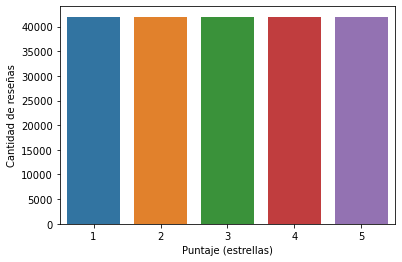

In [7]:
sns.countplot(x = 'stars', data = df_amazon)
plt.ylabel('Cantidad de reseñas')
plt.xlabel('Puntaje (estrellas)')

plt.show()

In [8]:
print('Existen',str(len(df_amazon['product_category'].unique())),'categorías únicas en el presente dataset')

Existen 30 categorías únicas en el presente dataset


Podemos observar que predominan las reseñas de productos línea **hogar** e **inalámbricos**, seguidos por **juguetes** y **deportes**

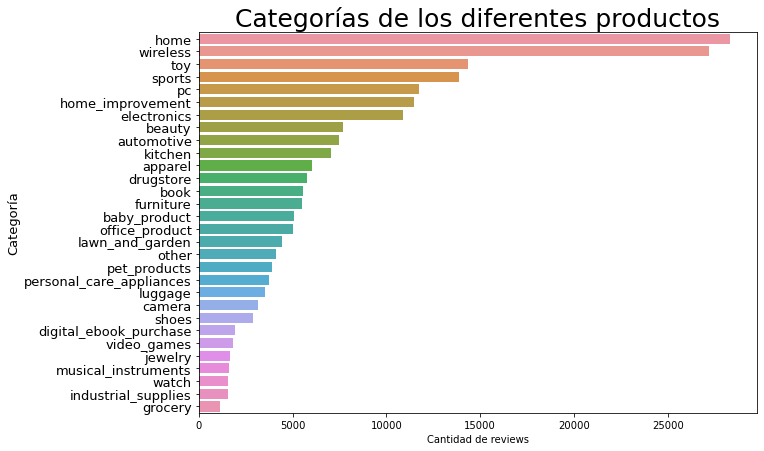

In [9]:
plt.figure(figsize = (10,7))

sns.countplot(y = 'product_category', 
              data = df_amazon,  
              order = df_amazon.product_category.value_counts().index)
plt.ylabel('Categoría',size=13)
plt.xlabel('Cantidad de reviews')
plt.tick_params(axis='y', labelsize=13)
plt.title('Categorías de los diferentes productos', size=25)
plt.show()

## Preprocesamiento de las reseñas

A continuación y con el motivo de poder analizar más fácilmente las reseñas, uniré en una misma columna <code>review_entero</code> las reseñas con sus títulos 

In [10]:
df_amazon['review_entero'] = df_amazon['review_title']+ ' ' + df_amazon['review_body']
df_amazon.reset_index(inplace=True,drop=True)
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  \
0                         Mala compra       es          wireless   
1                   No lo he recibido       es           apparel   
2  Que no aprieta bien en el manillar       es            sports   
3               Brocas de mantequilla       es  home_improvement   
4                         No me gusta       es            beauty   

                                       review_entero  
0  Mala compra Malisimo, muy grande demasiado apa...  
1  No lo he recibido No he recibido el pedido no ...  
2  Que no aprieta bien en el manillar Tengo que b...  
3  Brocas de mantequilla Utilicé las brocas de me...  
4  No me gusta No me gusta su olor a viejo y aspe...

En la siguiente celda:
- Cargo el <code>pipeline</code> en español de <code>spaCy</code>. Este, como se puede observar en el diagrama de abajo, aplica algunas transformaciones al texto que pasemos a través suyo. De acuerdo con la documentación del mismo, las transformaciones aplicadas son: <code>tok2vec</code>, <code>morphologizer</code>, <code>parser</code>, <code>ner</code>, <code>attribute_ruler</code> y <code>lemmatizer</code>

<img src="https://d33wubrfki0l68.cloudfront.net/3ad0582d97663a1272ffc4ccf09f1c5b335b17e9/7f49c/pipeline-fde48da9b43661abcdf62ab70a546d71.svg" alt="Drawing" style="width: 600px;"/>

- Cargo las palabras comunes (stopwords) en español para luego filtrar las distintas 

In [11]:
nlp = es_core_news_sm.load()

sw = nlp.Defaults.stop_words

A través de la siguiente función se aplica <code>**normalizado**</code> al texto de cada fila. Esto incluye:
- El preprocesado mencionado anteriormente debido a la aplicación de <code>nlp</code>
- Todas las palabras pasan a ser minúsculas
- Se eliminan comas, puntos y palabras de 1 letra (por ejemplo "y", "a", etc)
- Se quitan las <code>stopwords</code>. Estas son palabras que carecen de significado por sí solas, como preposiciones, artículos, conjunciones, pronombres, etc.

El objetivo de este preprocesamiento, que reducirá el ruido del texto al eliminar las formas infleccionales y a veces derivacionalmente relacionadas a una base común*, es facilitar el posterior análisis de cada reseña mediante algoritmos de clasificación. De esta forma, se podrán predecir con mayor precisión la cantidad de estrellas que daría a un producto un usuario dada una reseña

*"**Stemming and lemmatization", Stanford, Cambridge University Press, 2008, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html**


McNary, Dave. “Keanu Reeves, Alex Winter Returning for ‘Bill and Ted Face the Music.’” Variety, Penske Media Corporation, 8 May 2018, variety.com/2018/film/news/bill-and-ted-3-keanu-reeves-alex-winter-1202802946/.

Si bien en la siguiente función el tokenizado y eliminación de stopwords de las primeras 2 líneas de la misma puede resultar redundante ya que esto es realizado posteriormente al llamar al pipeline de <code>spaCy</code>, esto se realizó de todas formas debido a que este malinterpreta palabras como "para" y las transforma en "parir", lo que afecta al resultado.

Al realizar un tokenizado inicial y eliminación de las stopwords antes de llamar a <code>nlp</code> puedo deshacerme de estas palabras que son las más frecuentes.

In [30]:
def procesar(texto):
    reseña_tk = nltk.RegexpTokenizer('\w+').tokenize(texto)
    reseña_tk_min = [word.lower() for word in reseña_tk if word.lower() not in sw]
    review_clean = ' '.join(reseña_tk_min)
    reseña_limpia = nlp(review_clean)
    reseña_lemm = [word.lemma_ for word in reseña_limpia]
    reseña_lemm = [t for t in reseña_lemm if len(t)>1]
    return reseña_lemm

A continuación, podemos ver un ejemplo de procesamiento:

In [31]:
x = 119
print("Texto sin procesar:")
print(df_amazon.review_entero[x])
print("----------------")
print("Texto procesado:")
print(procesar(df_amazon.review_entero[x]))

Texto sin procesar:
El producto no llegó Se inventaron la excusa más cutre para no enviarme el producto. Un terremoto hizo que no me llegara este producto.
----------------
Texto procesado:
['producto', 'inventar', 'excusar', 'cutre', 'enviarme', 'producto', 'terremoto', 'llegar', 'producto']


Aplico el procesamiento a cada fila de la columna <code>review_entero</code>

In [32]:
df_amazon['review_entero_tk'] = df_amazon.apply(lambda row: procesar(row['review_entero']), axis=1)

Debido a que el preprocesamiento del dataset consume muchos recursos y por lo tanto lleva algunas horas de ejecución, guardo esta instancia en un archivo Excel para su posterior carga a modo de checkpoint

In [33]:
df_amazon.to_excel('Preprocesado.xlsx')

In [ ]:
#df_amazon = pd.read_excel('Preprocesado.xlsx').drop(columns='Unnamed: 0')

In [ ]:
# lista = []
# for i in range(df_amazon.shape[0]):
#     titular = df_amazon.iloc[i].review_entero_tk #seleccionar el titular
#     titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
#     lista.append(titular)
#     df_amazon.review_entero_tk[i]=lista

In [ ]:
#df_amazon.review_entero_tk.head(3)[0]

Graficaré mediante la siguiente función las 5 palabras más comunes de cada grupo de reseñas (agrupadas por cantidad de estrellas)

5 palabras más comunes para críticas de 1 estrellas
    Palabras  Frecuencia
0   producto       10042
1     llegar        9823
2    comprar        9700
3       malo        8851
4  funcionar        7978
-------------


<ipython-input-34-44763c9775bf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)


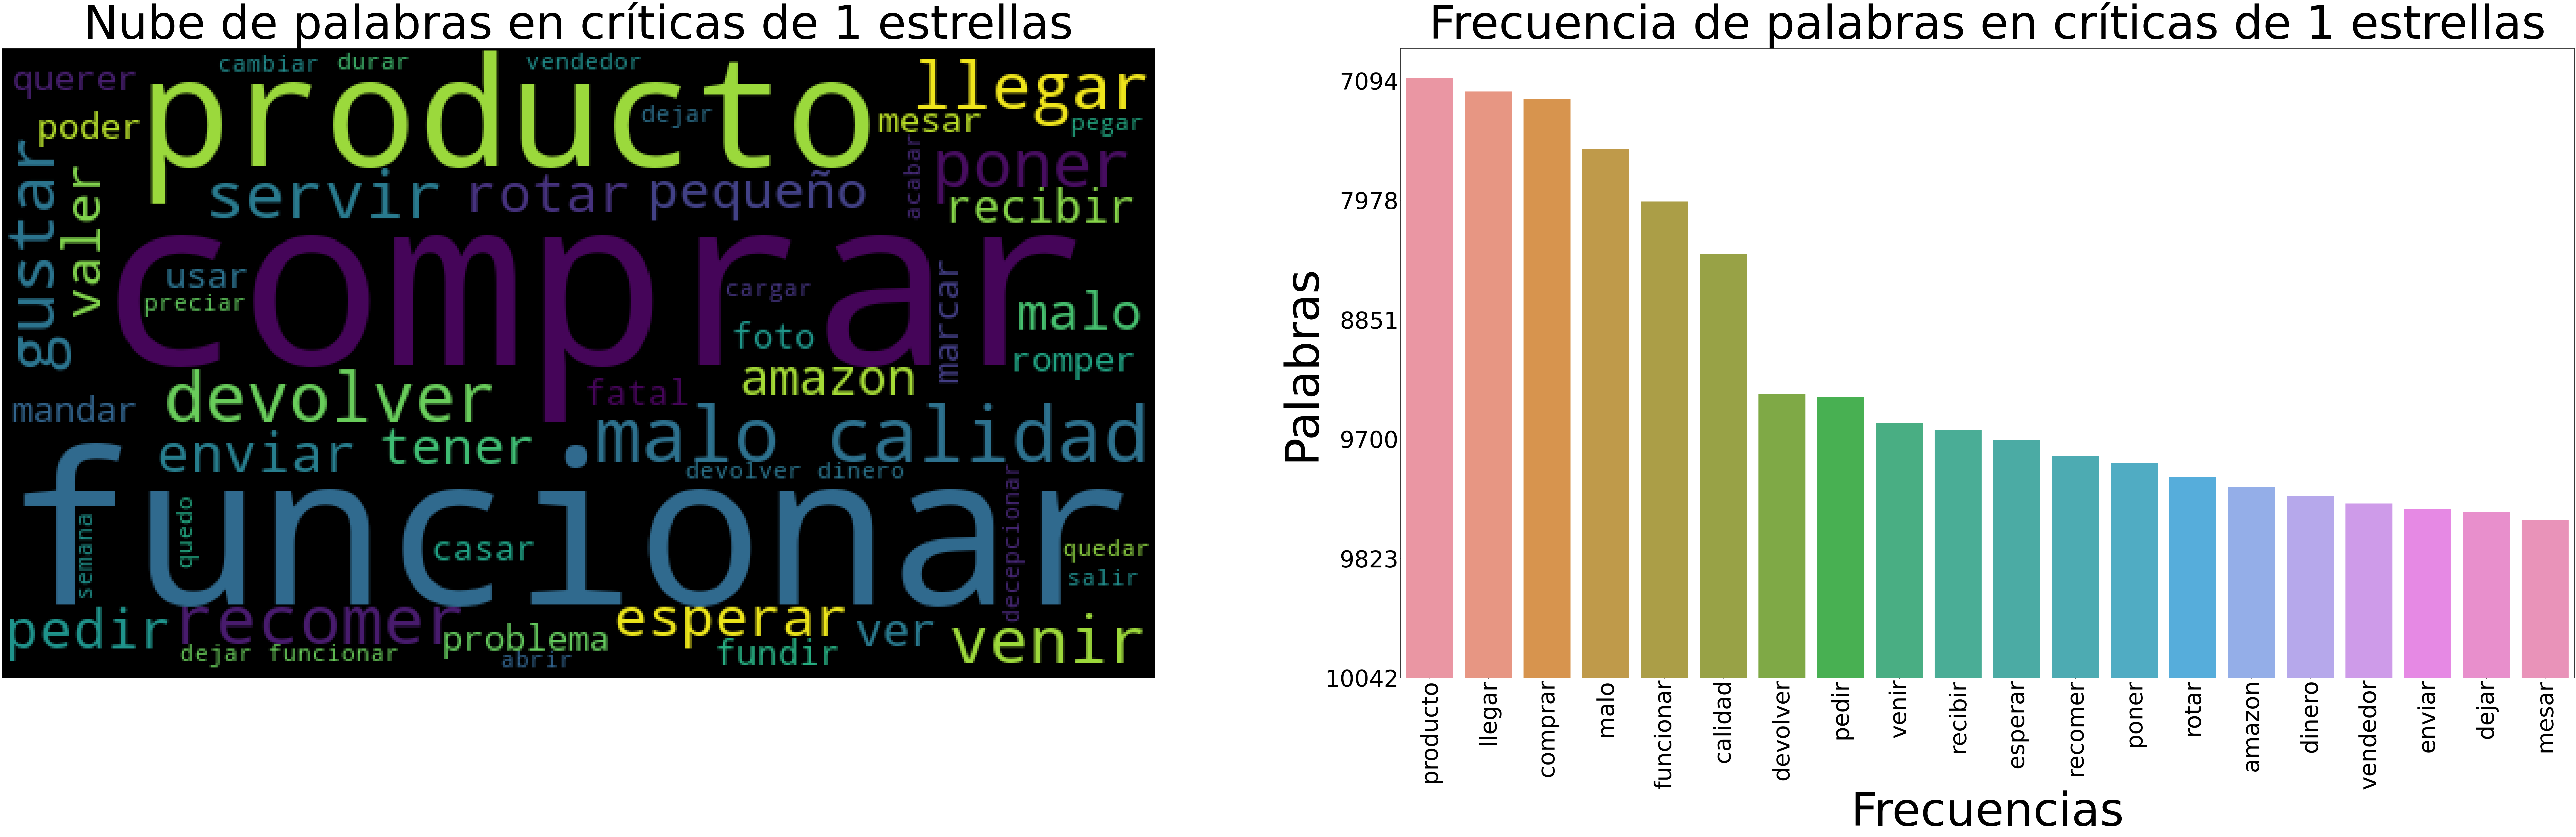

-------------
5 palabras más comunes para críticas de 2 estrellas
    Palabras  Frecuencia
0    calidad        9324
1    comprar        7415
2   producto        6158
3  funcionar        5897
4       malo        5314
-------------


<ipython-input-34-44763c9775bf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)


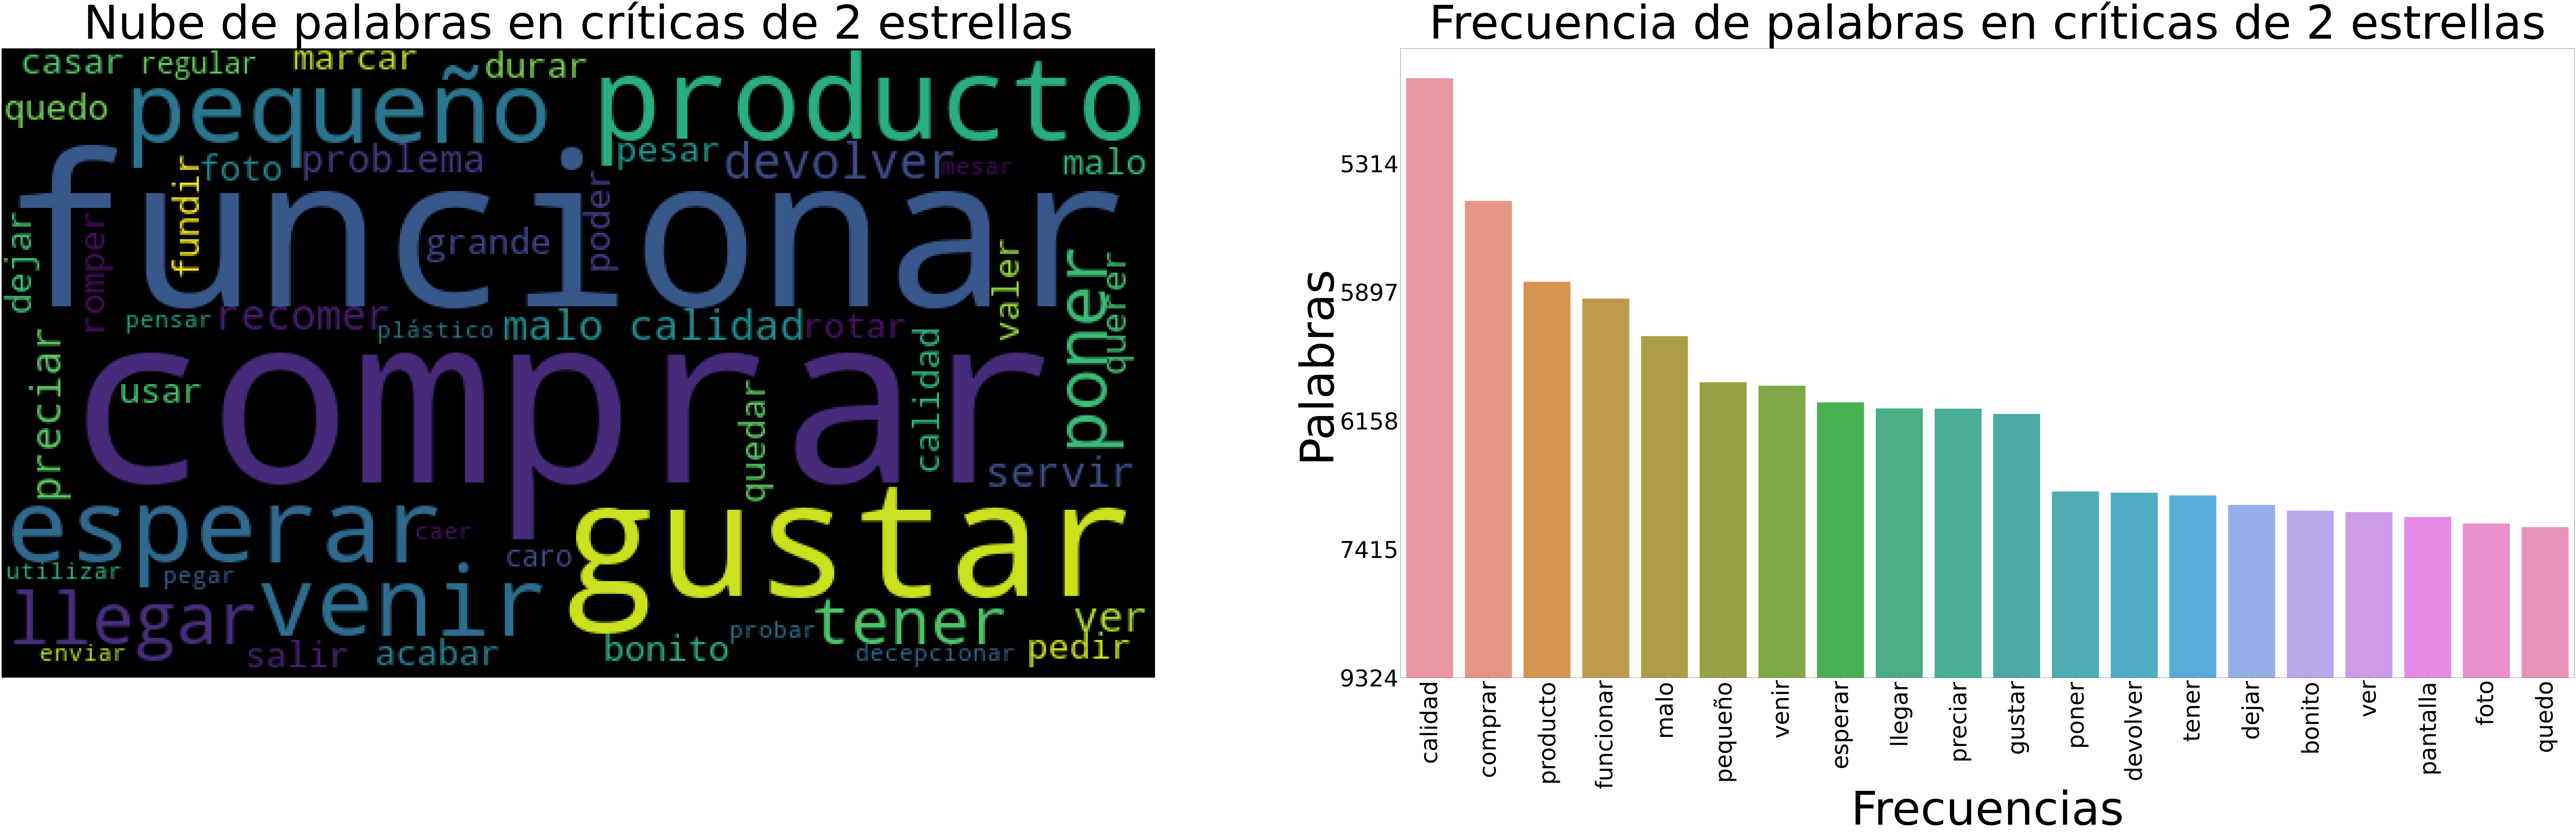

-------------
5 palabras más comunes para críticas de 3 estrellas
   Palabras  Frecuencia
0   calidad        8976
1   preciar        7663
2  producto        5495
3   pequeño        4968
4   comprar        4907
-------------


<ipython-input-34-44763c9775bf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)


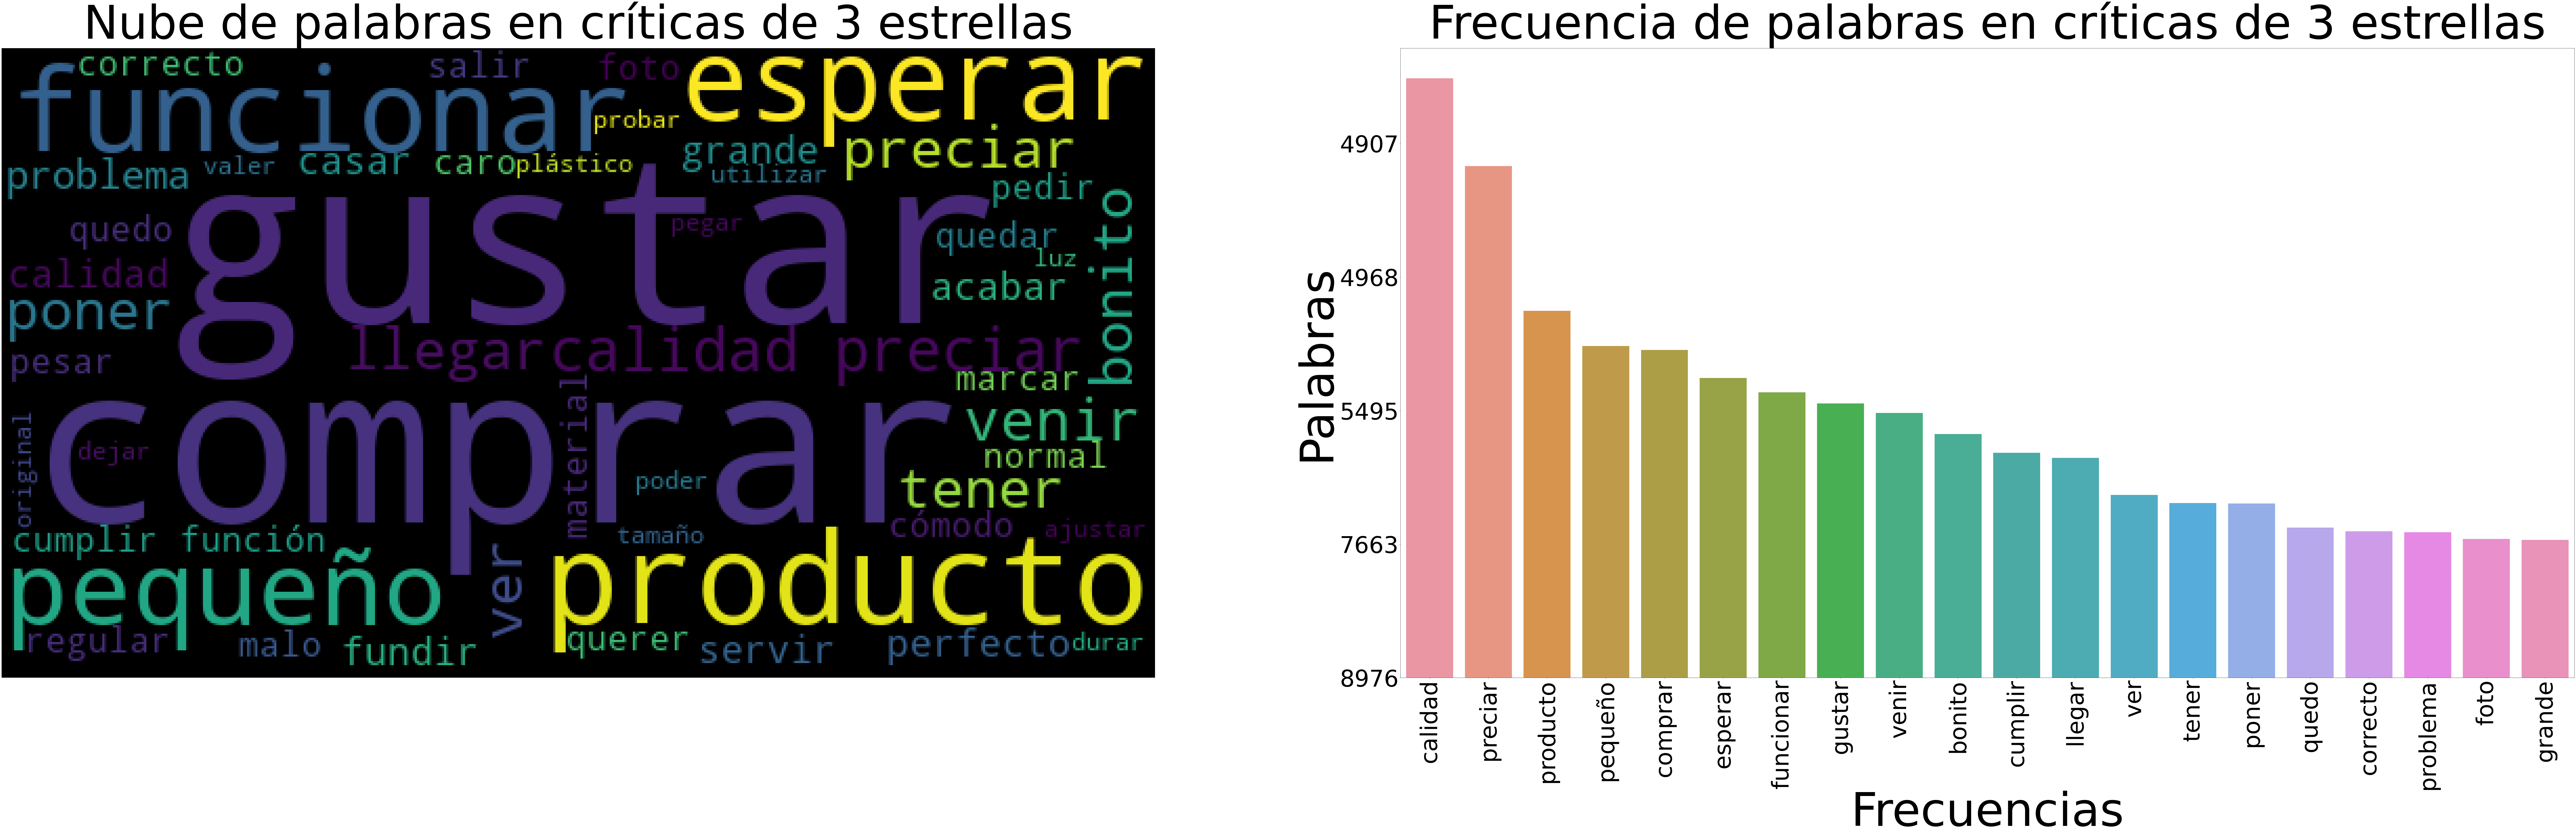

-------------
5 palabras más comunes para críticas de 4 estrellas
   Palabras  Frecuencia
0   calidad       11928
1   preciar       11013
2  producto        6728
3   comprar        6463
4  perfecto        5458
-------------


<ipython-input-34-44763c9775bf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)


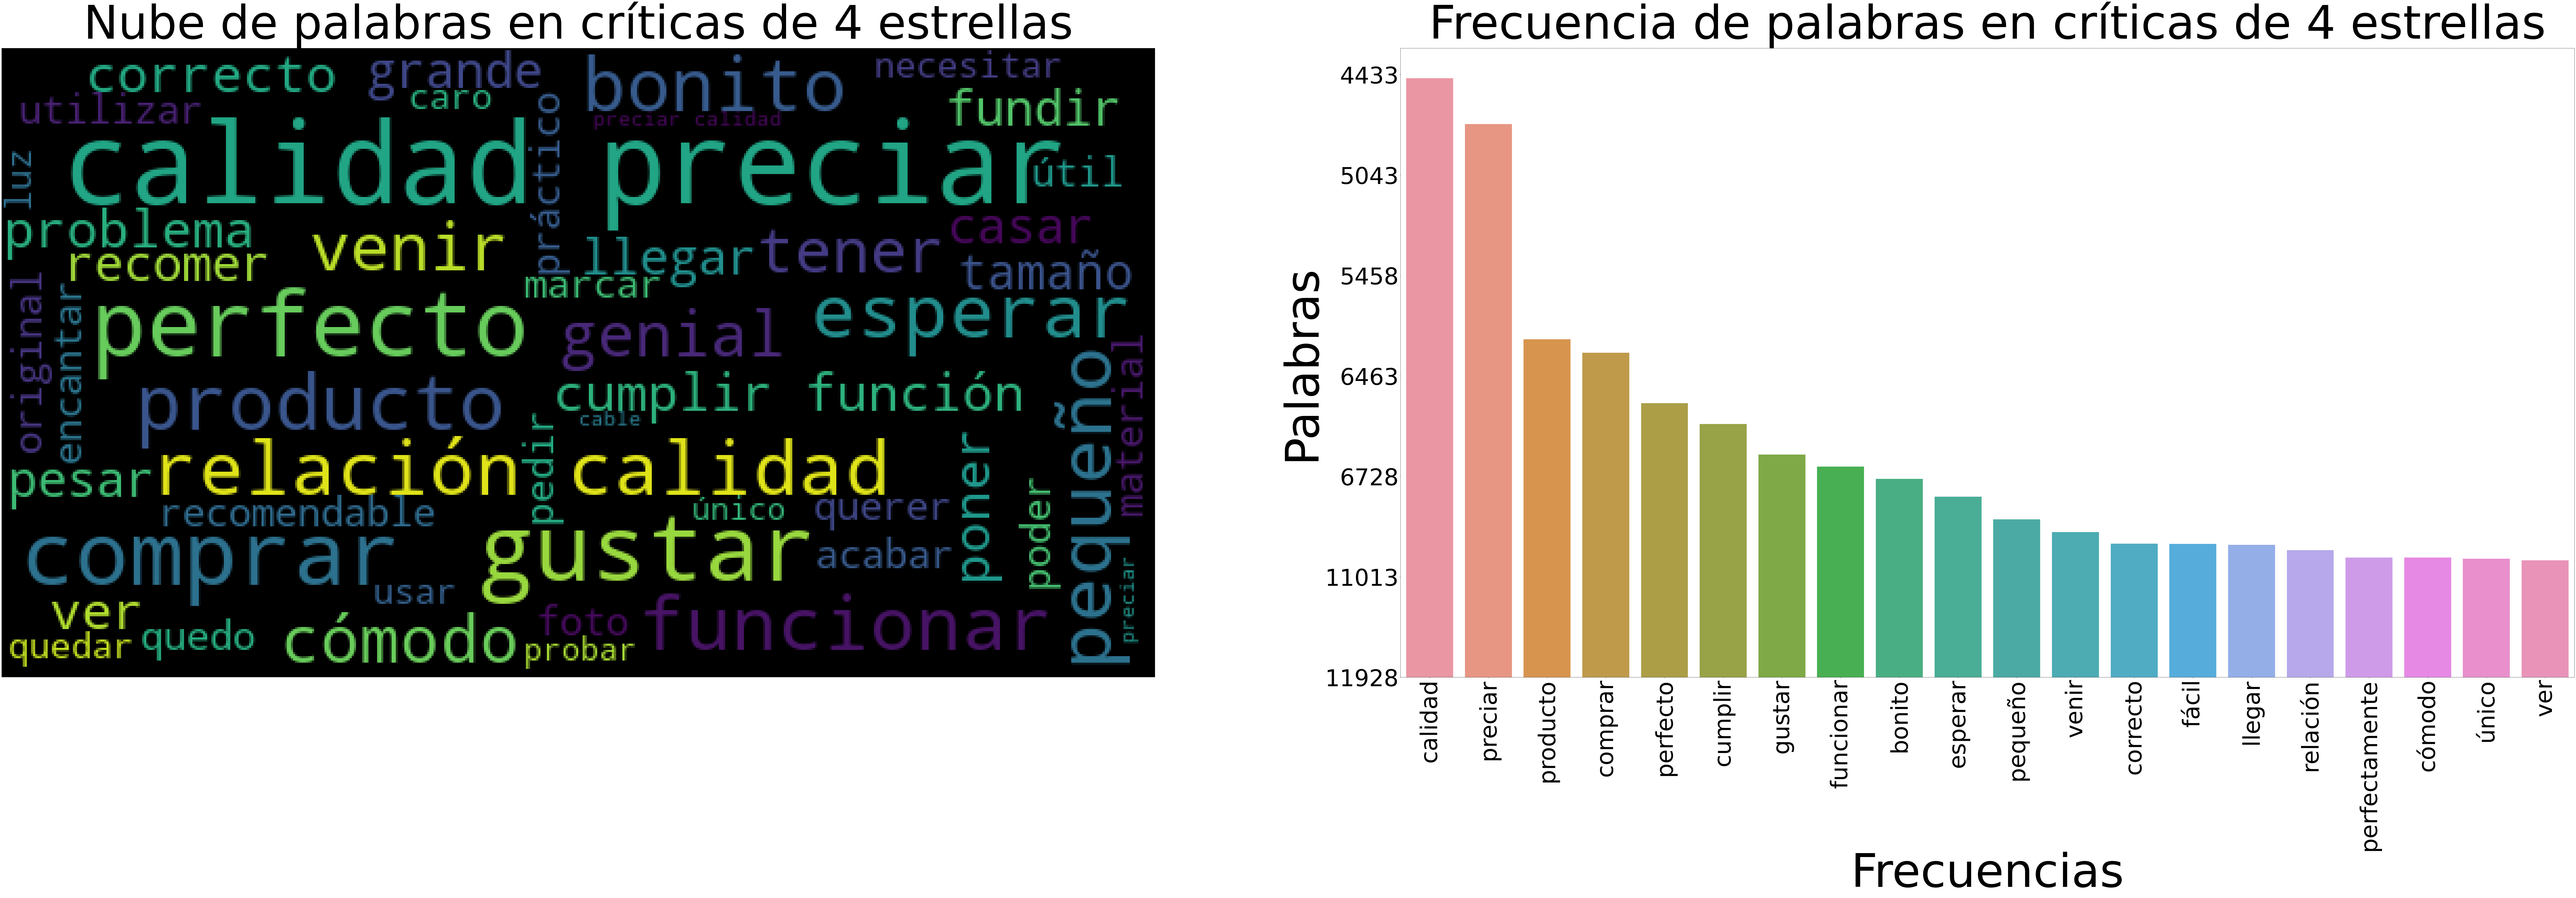

-------------
5 palabras más comunes para críticas de 5 estrellas
   Palabras  Frecuencia
0   calidad       12779
1  perfecto       11495
2   comprar        9202
3   preciar        8632
4  producto        6920
-------------


<ipython-input-34-44763c9775bf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)


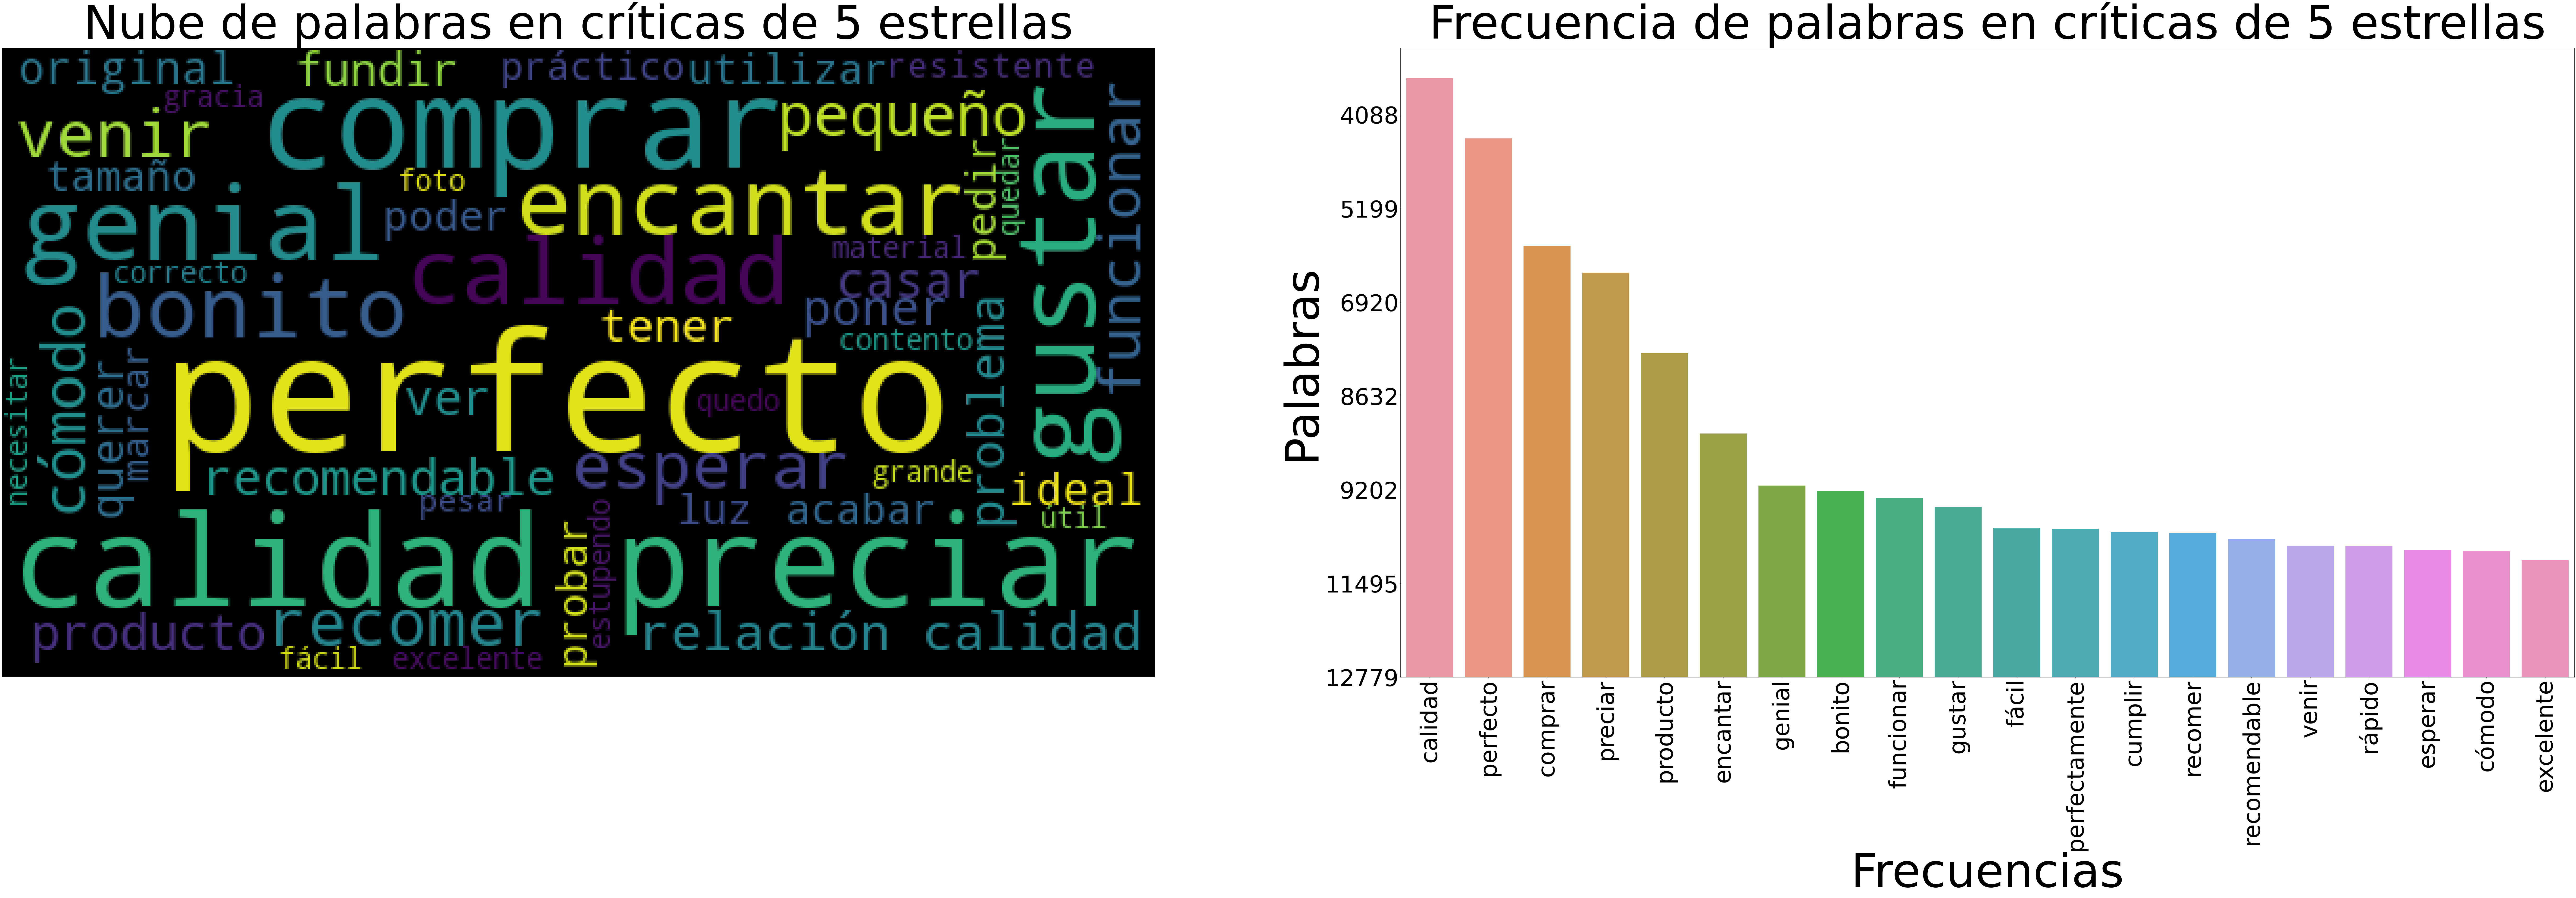

-------------


In [34]:
for x in range(1,6):
    tokenizado_df = df_amazon[df_amazon['stars']==x]
    tokenizado_lista = tokenizado_df.review_entero_tk.tolist()

    lista = [x for l in tokenizado_lista for x in l]

    frecuencia_palabras = Counter(lista)
    palabras_comunes = frecuencia_palabras.most_common()
    
    print(f'5 palabras más comunes para críticas de {x} estrellas')
    df_frec = pd.DataFrame(palabras_comunes, columns = ['Palabras', 'Frecuencia'])
    print(df_frec.head(5))
    print('-------------')
    
    tamaño_graficos = (200,50)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=tamaño_graficos)
    ax1 = plt.subplot(121)
    u_string=(" ").join(lista)
    wc = WordCloud(max_words = 50,width=tamaño_graficos[0]+350,height=tamaño_graficos[1]+250).generate(u_string)
    ax1.imshow(wc)
    ax1.axis("off")
    ax1.set_title(f'Nube de palabras en críticas de {x} estrellas', fontsize=200)

    ax2 = plt.subplot(122)
    ax2 = sns.barplot(ax=ax2,x = df_frec.iloc[:20].Palabras, y = df_frec.iloc[:20].Frecuencia)
    ax2.set_xticklabels(df_frec.iloc[:20].Palabras,fontsize = 100,rotation=90)
    ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)
    ax2.set_ylabel('Palabras',fontsize=200)
    ax2.set_xlabel('Frecuencias',fontsize=200)
    ax2.figure.set_size_inches(tamaño_graficos[0],tamaño_graficos[1])
    ax2.set_title(f'Frecuencia de palabras en críticas de {x} estrellas',fontsize=200)
    ax2.axis("on")
    plt.show()    
    
    print('-------------')

# B - Machine Learning

## Selección de métrica
En primer lugar, cabe aclarar que el problema se trata de clasificación de textos cortos en 5 escalas, tomando como entrada una reseña y devolviendo a partir de ella una predicción sobre cuál será el puntaje dado por el usuario para la compra hecha. Se trata, entonces, de un caso de **clasificación**.

Como se puede observar en la celda nº 7, existen igual cantidad de reseñas para cada cantidad de estrellas, lo que implica que el dataset está perfectamente balanceado. Para este tipo de casos, se suele recomendar la utilización de la métrica <code>**Accuracy**</code>. Además, también graficaré la <code>**Matriz de confusión**</code> de cada uno para poder visualizar de qué forma los diferentes modelos clasifican los comentarios de diferentes escalas.

## Transformaciones

Trabajaré con los datasets provistos inicialmente. Estos son:
- <code>**df**</code>
- <code>**df_test**</code>
- <code>**df_train**</code>

In [35]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

Para facilitar el tratamiento de datos, uniré las reseñas con sus títulos en una misma columna (<code>reseña_entera</code>), pasando el texto a minúsculas, eliminando los atributos <code>review_body</code> y <code>review_title</code> que contienen esta información por separado y descartando todas las otras columnas

In [36]:
df['reseña_entera'] = df['review_title'] + ' ' + df['review_body']
df['reseña_entera'] = df['reseña_entera'].str.lower()
df = df.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

df_test['reseña_entera'] = df_test['review_title'] + ' ' + df_test['review_body']
df_test['reseña_entera'] = df_test['reseña_entera'].str.lower()
df_test = df_test.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

df_train['reseña_entera'] = df_train['review_title'] + ' ' + df_train['review_body']
df_train['reseña_entera'] = df_train['reseña_entera'].str.lower()
df_train = df_train.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

In [38]:
df_train.head(5)

stars product_category                                      reseña_entera
0      1      electronics  television nevir nada bueno se me fue ka panta...
1      1      electronics  dinero tirado a la basura con esta compra horr...
2      1        drugstore  solo llega una unidad cuando te obligan a comp...
3      1         wireless  producto no recibido. no entro en descalificar...
4      1            shoes      devuelto llega tarde y co la talla equivocada

Aplico el procesamiento a los 3 dataframes por separado

In [39]:
df['reseña_entera_tk'] = df.apply(lambda row: procesar(row['reseña_entera']), axis=1)
df_test['reseña_entera_tk'] = df_test.apply(lambda row: procesar(row['reseña_entera']), axis=1)
df_train['reseña_entera_tk'] = df_train.apply(lambda row: procesar(row['reseña_entera']), axis=1)

In [40]:
df.to_excel('ml_df.xlsx')
df_test.to_excel('ml_df_test.xlsx')
df_train.to_excel('ml_df_train.xlsx')

In [41]:
df.head(5)

stars  product_category                                      reseña_entera  \
0      1          wireless  mala compra malisimo, muy grande demasiado apa...   
1      1           apparel  no lo he recibido no he recibido el pedido no ...   
2      1            sports  que no aprieta bien en el manillar tengo que b...   
3      1  home_improvement  brocas de mantequilla utilicé las brocas de me...   
4      1            beauty  no me gusta no me gusta su olor a viejo y aspe...   

                                    reseña_entera_tk  
0  [malo, comprar, malisimo, grande, aparatoso, p...  
1              [recibir, recibir, pedir, devolución]  
2  [apretar, manillar, buscar, sistema, funcionar...  
3  [broca, mantequilla, utilizar, broca, menor, d...  
4       [gustar, gustar, olor, viejo, aspecto, malo]

In [42]:
df['reseña_entera_tk'] = df['reseña_entera_tk'].apply(str)
df_test['reseña_entera_tk'] = df_test['reseña_entera_tk'].apply(str)
df_train['reseña_entera_tk'] = df_train['reseña_entera_tk'].apply(str)

In [43]:
df.head(4)

stars  product_category                                      reseña_entera  \
0      1          wireless  mala compra malisimo, muy grande demasiado apa...   
1      1           apparel  no lo he recibido no he recibido el pedido no ...   
2      1            sports  que no aprieta bien en el manillar tengo que b...   
3      1  home_improvement  brocas de mantequilla utilicé las brocas de me...   

                                    reseña_entera_tk  
0  ['malo', 'comprar', 'malisimo', 'grande', 'apa...  
1      ['recibir', 'recibir', 'pedir', 'devolución']  
2  ['apretar', 'manillar', 'buscar', 'sistema', '...  
3  ['broca', 'mantequilla', 'utilizar', 'broca', ...

A continuación, aplicaré vectorización a través del factor de ponderación <code>**Tf-idf**</code>. Este determina la relevancia de una palabra a partir de la frecuencia con la que aparece en un documento presente en una colección de documentos.

Al tener en cuenta la frecuencia *inversa* dentro de la colección de documentos, este ponderador puede atenuar el efecto que produce que algunas palabras sean más comunes en la misma.

Un peso alto en <code>**Tf-idf**</code> se alcanza con una elevada frecuencia de término (en el documento dado) y una pequeña frecuencia de ocurrencia del término en la colección completa de documentos

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [45]:
lista_reseñas_test = list(df_test['reseña_entera_tk'].values) #test
calif_test = df_test['stars'].values

lista_reseñas_train = list(df_train['reseña_entera_tk'].values) #train
calif_train = df_train['stars'].values 

lista_reseñas = list(df['reseña_entera_tk'].values) #data dev
calif = df['stars'].values 

#TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, min_df=30)

#Transformo en matriz
matriz_reseña_test= tfidf.fit_transform(lista_reseñas_test)
matriz_reseña_train = tfidf.transform(lista_reseñas_train)
matriz_reseña_dev = tfidf.transform(lista_reseñas)

print('Train', matriz_reseña_train.shape)
print('Test', matriz_reseña_test.shape)
print('Data dev ', matriz_reseña_dev.shape)

Train (200000, 340)
Test (5000, 340)
Data dev  (5000, 340)


In [46]:
matriz_reseña_train = matriz_reseña_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_reseña_test = matriz_reseña_test.astype('float32')
calif_test= calif_test.astype('int8')

matriz_reseña_dev = matriz_reseña_dev.astype('float32')
calif= calif.astype('int8')

In [47]:
#TRAIN
X_train = matriz_reseña_train.toarray()
y_train = calif_train

#TEST
X_test = matriz_reseña_test.toarray()
y_test = calif_test

#DATA
X = matriz_reseña_dev.toarray()
y = calif

## Entrenamiento de modelos

A continuación, entrenaré un modelo Naive-Bayes y lo consideraré modelo base para comparar su rendimiento con distintos modelos de clasificación

In [48]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

A continuación, probaré distintos modelos de ML para ver sus rendimientos

In [63]:
random_forest = RandomForestClassifier(max_depth=50, 
                                       random_state=50)
random_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, random_state=50)

In [60]:
svc = LinearSVC(C = 10, random_state=50)
svc.fit(X_train, y_train)

LinearSVC(C=10, random_state=50)

## Predicciones y resultados

In [51]:
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))

Accuracy train NB:  0.414865
Accuracy test NB:  0.4212


In [64]:
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

print("Accuracy train Random Forest: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test Random Forest: ", accuracy_score(y_test, y_test_pred_rf))

Accuracy train Random Forest:  0.730215
Accuracy test Random Forest:  0.4464


In [61]:
y_train_pred_svc= svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))

Accuracy train SVC:  0.46213
Accuracy test SVC:  0.4652


El modelo que presenta mayor accuracy en test es el de <code>SVC</code>. El hecho que Random Forest presente una marcada mayor precisión sobre el dataset de *entrenamiento* pero no sobre el de *prueba* revela que este presenta **overfitting**

A continuación, graficaré las matrices de confusión para los modelos seleccionados

Modelo: Naive-Bayes


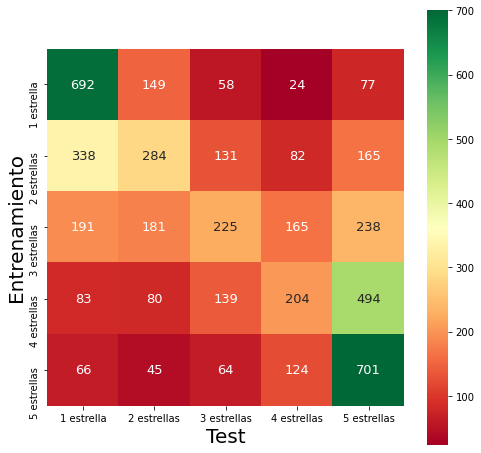

Modelo: Random Forest


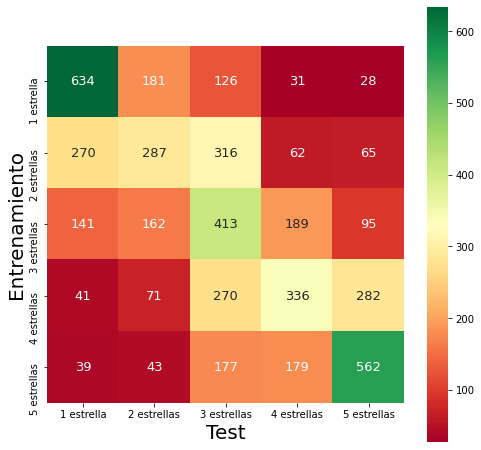

Modelo: SVC


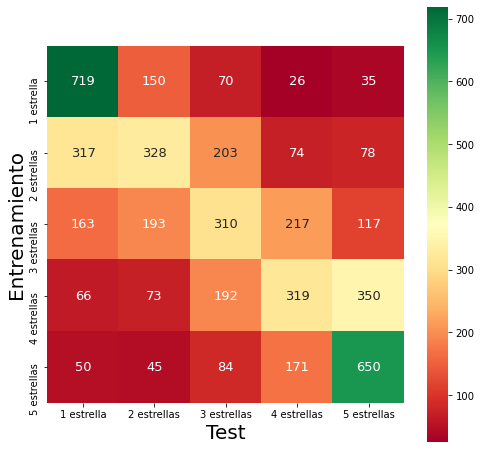

In [65]:
lista_modelos = ([y_test_pred,'Naive-Bayes'],[y_test_pred_rf,'Random Forest'],[y_test_pred_svc,'SVC'])

for i in range(0,3):
    print('Modelo: '+lista_modelos[i][1])
    calificacion=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm = confusion_matrix(y_test,lista_modelos[i][0])
    f,ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

    plt.xlabel("Test", size =20)
    plt.ylabel("Entrenamiento", size =20)
    ax.set_xticklabels(calificacion)
    ax.set_yticklabels(calificacion)
    plt.show()

Puedo concluir a partir de estos resultados que <code>Random Forest</code> es el que mejor predice resultados intermedios (**3 estrellas**), mientras que los otros 2 cuentan con mayor precisión en las reseñas con una tendencia más marcada (**1 ó 5 estrellas**). Esto se puede corroborar en las nubes de palabras, donde la mayoría de las palabas utilizadas son comunes para las reseñas entre 2 y 4 estrellas, mientras que en las más extremas presentan palabras particulares, como "malo" o "excelente"

Sin embargo, la precisión es marcadamente mejor en el SVC, además de que en el de Random Forest existe overfitting, por lo que el mejor modelo sigue siendo el de SVC.

## Optimización

Dados los rendimientos del modelo <code>SVC</code>, intentaré optimizar sus hiperparámetros para poder mejorar su capacidad predictiva.

Para esto, aplicaré <code>Random Search</code>, o búsqueda aleatoria a sus hiperparámetros:
    - <code>Penalty<code>
    - <code><code>
    - <code><code>
    - <code><code>

In [68]:
svc_optimizado = LinearSVC(random_state = 50)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  
              'penalty': ['l1', 'l2'],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
             'multi_class': ['ovr', 'crammer_singer']}
modelo_nuevo = RandomizedSearchCV(svc_optimizado, param_grid, cv=3, scoring = 'accuracy',n_jobs=-1,n_iter=30,random_state=50) 
modelo_nuevo.fit(X_train, y_train)

NameError: name 'grid' is not defined

In [ ]:
y_train_pred_svc= grid.predict(X_train)
y_test_pred_svc = grid.predict(X_test)

print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))